### Tomar decisiones de Negocio basadas en Datos.

#### 0. Introducción
Soy analista en una gran tienda en línea. Junto con el departamento de marketing, hemos compilado una lista de hipótesis que pueden ayudar a aumentar los ingresos.

Necesito priorizar estas hipótesis, realizar una prueba A/B y analizar los resultados.

#### Descripcion de la data <br />

### Conjunto de datos "hypotheses_us.csv"
- **Hypotheses** — descripciones breves de las hipótesis
- **Reach** — alcance de los usuarios, en una escala del uno al diez
- **Impact** — impacto en los usuarios, en una escala del uno al diez
- **Confidence** — confianza en la hipótesis, en una escala del uno al diez
- **Effort** — los recursos necesarios para probar una hipótesis, en una escala del uno al diez. Cuanto mayor sea el valor de Effort, más intensiva en recursos será la prueba.

### Conjunto de datos "orders_us.csv"
- **transactionId** — identificador del pedido
- **visitorId** — identificador del usuario que realizó el pedido
- **date** — fecha del pedido
- **revenue** — ingresos del pedido
- **group** — el grupo de la prueba A/B al que pertenece el usuario

### Conjunto de datos "visits_us.csv"
- **date** — fecha
- **group** — grupo de la prueba A/B
- **visits** — el número de visitas en la fecha especificada en el grupo de prueba A/B especificado

#### 1. Descargar data y prepararla para analizarla.

In [1]:
import pandas   as pd
from scipy import stats as st
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
pd.options.display.float_format = "{:.2f}".format
pd.set_option('display.max_colwidth', 400)

##### Análisis preliminar de la estructura de datos

In [2]:
hypotheses = pd.read_csv("datasets/hypotheses_us.csv", delimiter=";")
visits = pd.read_csv('datasets/visits_us.csv')
orders = pd.read_csv("datasets/orders_us.csv")

In [3]:
print('Hipotesis: \n')
print(hypotheses.info())

Hipotesis: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes
None


In [4]:
print('Visitas: \n')
print(visits.info(),'\n')
print(visits['group'].value_counts())


Visitas: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None 

group
A    31
B    31
Name: count, dtype: int64


Necesitamos convertir el campo "Group" al tipo categoría, y el campo "Date" al tipo DateTime.

In [5]:
print('Orders: \n')
print(orders.info(),'\n')
print(orders['group'].value_counts())

Orders: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB
None 

group
B    640
A    557
Name: count, dtype: int64


Necesitamos convertir el campo "group" al tipo categoría, y el campo "date" al tipo DateTime.

#### 1.2. Procesamiento de Data

In [6]:
hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


In [7]:
print('Duplicados encontrados - ',hypotheses['Hypothesis'].duplicated().sum(),' records')
hypotheses

Duplicados encontrados -  0  records


,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


In [8]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [9]:
print('Duplicados encontrados - ',visits[['date','group']].duplicated().sum(),' records')
visits[:5]

Duplicados encontrados -  0  records


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [11]:
print("Duplicados encontrados - ", orders.duplicated().sum(), " records")
orders[:5]

Duplicados encontrados -  0  records


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.40,B
1,2804400009,3642806036,2019-08-15,15.20,B
2,2961555356,4069496402,2019-08-15,10.20,A
3,3797467345,1196621759,2019-08-15,155.10,B
4,2282983706,2322279887,2019-08-15,40.50,B


In [12]:
group_nunique = orders.groupby('visitorId', as_index = False).agg({'group':'nunique'})
incorrect_data = group_nunique[group_nunique['group'] == 2]
print('Existen {:} clientes que participan en ambos grupos.'.format(len(incorrect_data)))

Existen 58 clientes que participan en ambos grupos.


##### Conclusion:<br>
No se encontraron datos faltantes.<br>
No se encontraron duplicados.<br>
No es necesario convertir el tipo de datos.<br>
Para mayor comodidad, necesitamos renombrar las columnas. Pondremos todas las letras en minúsculas.

Sin embargo, resultó que hay 58 compradores que están presentes en ambos grupos. Esto arruinará el resultado de la prueba. Necesitamos eliminar los datos sobre estos clientes de las tablas **Orders** y **Visits**.

In [13]:
hypotheses = hypotheses.rename(str.lower, axis='columns')

In [14]:
# Hagamos una lista de clientes que participan en dos grupos al mismo tiempo.
customer_exclude = orders.groupby('visitorId', as_index = False).agg({'group':'nunique'})
customer_exclude = list(customer_exclude.query('group == 2')['visitorId'])

In [15]:
# Eliminemos los datos del cliente de la tabla Pedidos, que se incluyen en la lista "customer_exclude".
orders_filtred = orders.query('visitorId not in @customer_exclude')

In [16]:
# Eliminemos los datos de los clientes de la tabla Visitas, que se incluyen en la lista "customer_exclude".
orders_temp = orders.query('visitorId in @customer_exclude').reset_index(drop = True)
# Agregar columna "Correcta" con visita "-1"
orders_temp.loc[:,'corr'] = -1
orders_correcting_info = orders_temp.groupby(['date','group']).agg({'corr':'sum'}).fillna(0).reset_index(drop=False)
orders_correcting_info['corr'] = orders_correcting_info['corr'].astype(int)

visits_filtred = visits.merge(orders_correcting_info,
                              left_on=['date', 'group'],
                              right_on=['date', 'group'])

visits_filtred['visits'] = visits_filtred['visits'] + visits_filtred['corr'] 
visits_filtred = visits_filtred.drop('corr', axis=1)

In [17]:
visits[:6]

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667


In [18]:
visits_filtred[:6]

,date,group,visits
0,2019-08-01,A,718
1,2019-08-02,A,618
2,2019-08-04,A,712
3,2019-08-05,A,753
4,2019-08-06,A,664
5,2019-08-07,A,642


### 2. Priorizar hipótesis

#### 2.1 ICE<a name="ice"></a>

In [19]:
#  ICE
hypotheses['ice'] = hypotheses.apply(lambda x: 
                                     x['impact'] * x['confidence'] / x['effort'],
                                     axis=1)

hypotheses = hypotheses.sort_values(by='ice', ascending = False).reset_index(drop=True)
hypotheses

,hypothesis,reach,impact,confidence,effort,ice
0,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.20
1,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.33
2,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.20
3,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.00
4,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.00
5,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.00
6,Add a customer review page. This will increase the number of orders,3,2,2,3,1.33
7,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.12
8,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.00


In [20]:
# fijemos prioridades
hypotheses['priority_ice'] = (
    hypotheses.apply(lambda x: hypotheses[hypotheses['hypothesis'] == x['hypothesis']]
                     .index.values[0],
                     axis=1))
hypotheses[['hypothesis','ice','priority_ice']]
hypotheses['priority_ice'] = 9 - hypotheses['priority_ice']

#### 2.2 RICE<a name="rice"></a>

In [21]:
hypotheses['rice'] = hypotheses.apply(lambda x: 
                                      x['impact'] * x['confidence'] * x['reach'] / x['effort'],
                                      axis=1)
hypotheses = hypotheses.sort_values(by='rice', ascending = False).reset_index(drop=True)

In [22]:
# fijemos prioridades
hypotheses['priority_rice'] = (
    hypotheses.apply(lambda x: hypotheses[hypotheses['hypothesis'] == x['hypothesis']].
                     index.values[0],
                     axis=1))
hypotheses[['hypothesis','rice','priority_rice']]
hypotheses['priority_rice'] = 9 - hypotheses['priority_rice']

In [23]:
# Calcula cuántas posiciones ha cambiado la prioridad
hypotheses['shift'] = hypotheses.apply(lambda x: x['priority_rice'] - x['priority_ice'], axis=1)

In [24]:
def color_negative_red(val):
    color = 'red' 
    if val >= 0:
        color = 'green'
    return 'color: %s' % color

In [25]:
( 
    hypotheses[['hypothesis','priority_rice','priority_ice','shift']].
    style.
    applymap(color_negative_red, 
             subset=['shift'])
)  

C:\Users\User\AppData\Local\Temp\ipykernel_19392\2846138334.py:4: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  applymap(color_negative_red,


,hypothesis,priority_rice,priority_ice,shift
0,Add a subscription form to all the main pages. This will help you compile a mailing list,9,7,2
1,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,5,3
2,Add two new channels for attracting traffic. This will bring 30% more users,7,8,-1
3,Show banners with current offers and sales on the main page. This will boost conversion,6,6,0
4,Launch a promotion that gives users discounts on their birthdays,5,9,-4
5,Change the category structure. This will increase conversion since users will find the products they want more quickly,4,2,2
6,Launch your own delivery service. This will shorten delivery time,3,4,-1
7,Add a customer review page. This will increase the number of orders,2,3,-1
8,Change the background color on the main page. This will increase user engagement,1,1,0


##### Conclusion:<br />
Como podemos ver, al asignar una calificación de priorización a RICE e ICE, las hipótesis tienen diferentes prioridades. La columna "shift" muestra cuántas posiciones cambió la prioridad cuando priorizamos usando el método RICE. Como podemos ver, la prioridad ha aumentado para aquellas hipótesis para las cuales el alcance potencial de la audiencia (REACH) fue mayor. Cuantas más personas afecte nuestra innovación, mayor será el resultado que obtendremos.

### 3. A/B Test

#### 3.1 Grafique los ingresos acumulados por grupo.

In [26]:
orders_filtred[:5]

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.40,B
1,2804400009,3642806036,2019-08-15,15.20,B
3,3797467345,1196621759,2019-08-15,155.10,B
4,2282983706,2322279887,2019-08-15,40.50,B
5,182168103,935554773,2019-08-15,35.00,B


In [27]:
dateGroup = orders_filtred[['date','group']].sort_values(by = 'date').drop_duplicates()
dateGroup[:5]

,date,group
103,2019-08-01,B
147,2019-08-01,A
209,2019-08-02,A
210,2019-08-02,B
344,2019-08-03,A


In [28]:
dateGroup['revenue'] = ( 
    dateGroup.
    apply(lambda x: orders_filtred[np.logical_and(orders_filtred['date'] <= x['date'],
                                                  orders_filtred['group'] == x['group'])]['revenue'].sum(),
          axis = 1)
)                            
dateGroup[:6] 

,date,group,revenue
103,2019-08-01,B,967.20
147,2019-08-01,A,2266.60
209,2019-08-02,A,3734.90
210,2019-08-02,B,3535.30
344,2019-08-03,A,5550.10
442,2019-08-03,B,4606.90


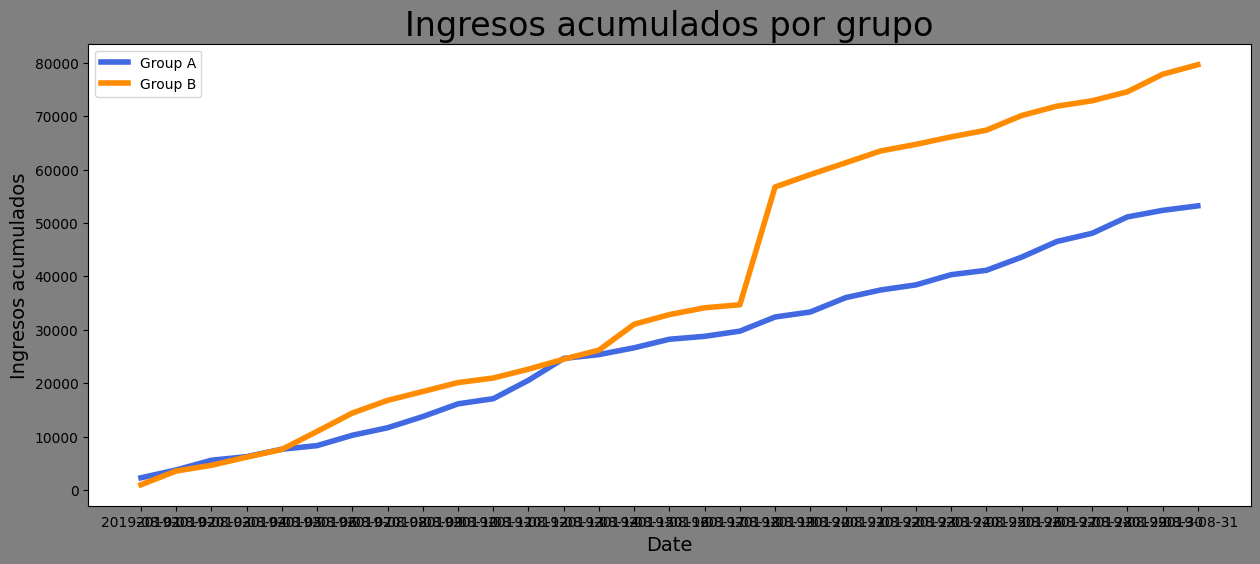

In [29]:
cumulativeRevenue_A = dateGroup[dateGroup['group'] == 'A']
cumulativeRevenue_B = dateGroup[dateGroup['group'] == 'B']

fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(cumulativeRevenue_A['date'],cumulativeRevenue_A['revenue'], 
         label = 'Group A', color = 'royalblue',linewidth=4.0) 
plt.plot(cumulativeRevenue_B['date'],cumulativeRevenue_B['revenue'], 
         label = 'Group B', color = 'darkorange',linewidth=4.0) 
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel("Ingresos acumulados", fontsize=14)
ax.set_title("Ingresos acumulados por grupo", fontsize=24)
fig.patch.set_facecolor('grey')
plt.legend()

plt.show()

##### Conclusión:<br />
Los ingresos están aumentando constantemente durante toda la prueba. Eso es una buena señal.<br />
Los ingresos acumulados en el grupo B son más altos que en el grupo A desde el comienzo de la prueba. Los gráficos tienen una tendencia similar, sin embargo, en el grupo B, hubo un salto anormal en los ingresos el 19/08/2019. En la siguiente parte, averiguaremos si es una anomalía o no.

#### 3.2 Graph cumulative average order size by group.<a name="cumulative_average_order_size"></a>

In [30]:
#Let's calculate the number of orders per day. (cumulative)
dateGroup['n_orders'] = ( 
    dateGroup.
    apply(lambda x: orders_filtred[np.logical_and(orders_filtred['date'] <= x['date'],
                                                  orders_filtred['group'] == x['group'])]
          ['transactionId'].count(),
          axis = 1)
)                            
dateGroup[:6] 

,date,group,revenue,n_orders
103,2019-08-01,B,967.20,17
147,2019-08-01,A,2266.60,23
209,2019-08-02,A,3734.90,42
210,2019-08-02,B,3535.30,40
344,2019-08-03,A,5550.10,66
442,2019-08-03,B,4606.90,54


In [31]:
dateGroup['avg_order_size'] = (
    dateGroup.apply(lambda x: x['revenue'] / x['n_orders'] , axis = 1)
)
cumulativeAvgOrdersSize_A = dateGroup[dateGroup['group'] == 'A']
cumulativeAvgOrdersSize_B = dateGroup[dateGroup['group'] == 'B']

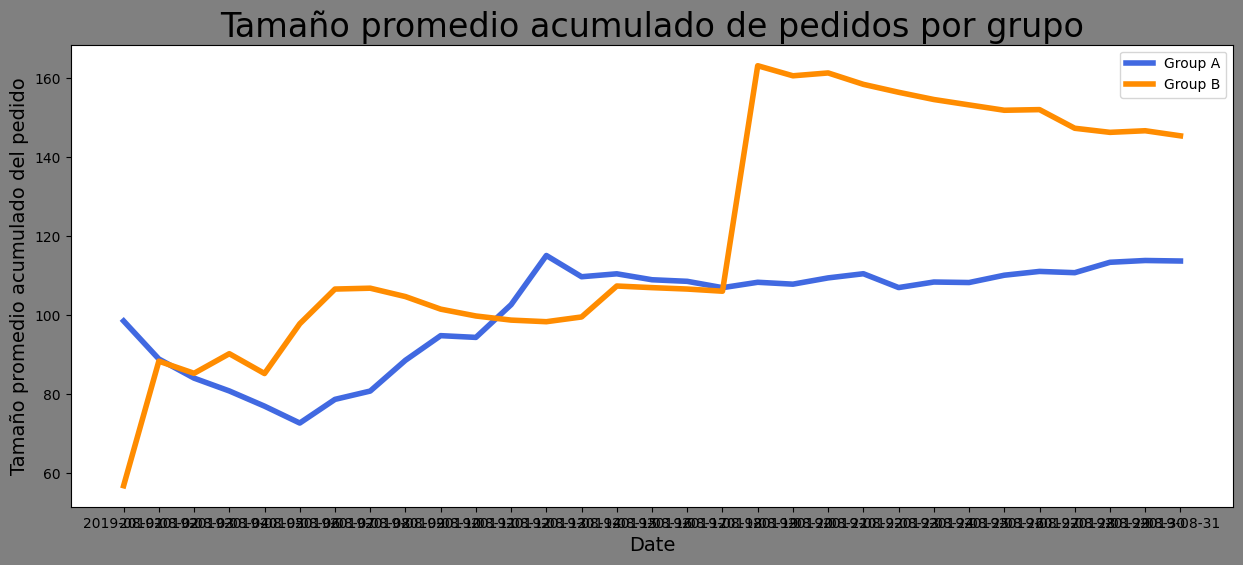

In [32]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(cumulativeAvgOrdersSize_A['date'], cumulativeAvgOrdersSize_A['avg_order_size'], 
         label = 'Group A', color = 'royalblue', linewidth=4.0) 
plt.plot(cumulativeAvgOrdersSize_B['date'], cumulativeAvgOrdersSize_B['avg_order_size'], 
         label = 'Group B', color = 'darkorange',linewidth=4.0) 
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel("Tamaño promedio acumulado del pedido", fontsize=14)
ax.set_title("Tamaño promedio acumulado de pedidos por grupo", fontsize=24)
fig.patch.set_facecolor('grey')
plt.legend()

plt.show()

##### Conclusión:<br />

El tamaño promedio de las compras también se vuelve estable hacia el final de la prueba: se estabiliza para el grupo A y sigue cayendo para el grupo B. El aumento en el grupo B el 18/08/2019 puede haberse debido a la presencia de pedidos grandes y costosos. Necesitamos más datos sobre este grupo para encontrar el tamaño promedio real de las compras y establecer su nivel.<br /><br />
Como podemos ver, el precio promedio de compra en el grupo B es más alto, pero la tendencia es descendente y no está claro a partir de los datos disponibles si el precio promedio de pedido en el grupo B caerá por debajo del grupo A.

#### 3.3 Grafique la diferencia relativa en el tamaño promedio acumulado de los pedidos del grupo B en comparación con el grupo A.

In [33]:
mergedCumulativeAvgOrdersSize = ( 
    cumulativeAvgOrdersSize_A[['date','avg_order_size']].
    merge(cumulativeAvgOrdersSize_B[['date','avg_order_size']], 
          on='date',
          suffixes=['A', 'B'])
)
mergedCumulativeAvgOrdersSize['relative_difference_avg_order_size'] = (
    mergedCumulativeAvgOrdersSize.
    apply(lambda x: (x['avg_order_sizeB'] / x['avg_order_sizeA']) - 1,
          axis = 1)
)

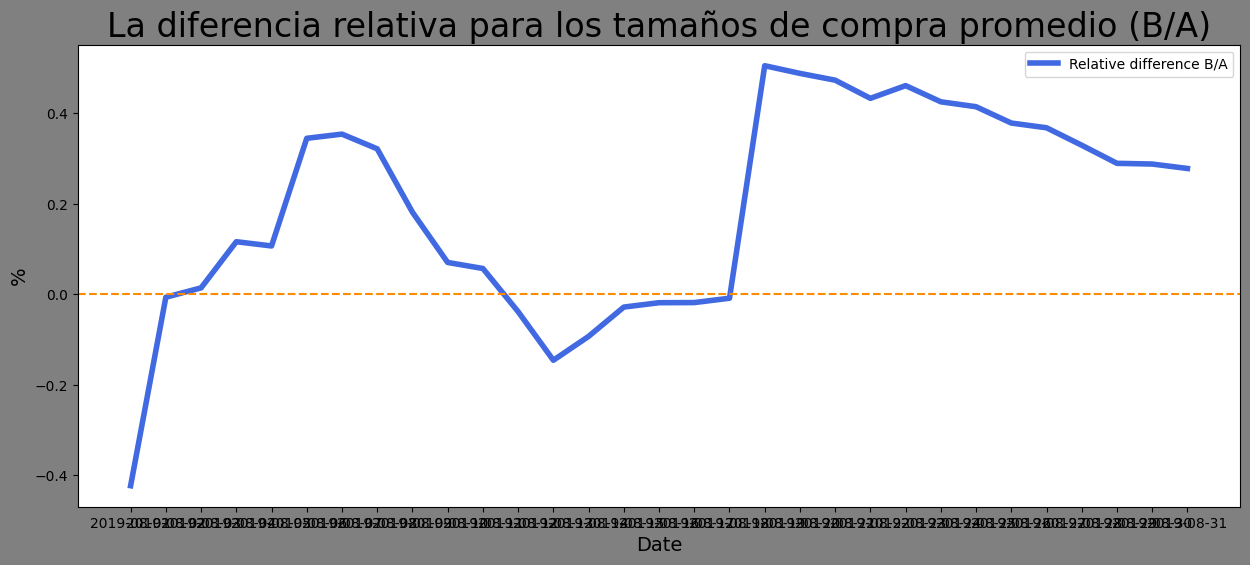

In [34]:
# trazar un gráfico de diferencia relativa para los tamaños de compra promedio
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(mergedCumulativeAvgOrdersSize['date'], 
         mergedCumulativeAvgOrdersSize['relative_difference_avg_order_size'], 
         label = 'Relative difference B/A', color = 'royalblue', linewidth=4.0) 
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('%', fontsize=14)
ax.set_title(
    "La diferencia relativa para los tamaños de compra promedio (B/A)", fontsize=24
)
fig.patch.set_facecolor('grey')
plt.axhline(y=0, color='darkorange', linestyle='--') 
plt.legend()

plt.show()

##### Conclusión: <br />
El gráfico tiene inversiones bruscas, lo que significa que hay pedidos anormalmente grandes en ambos grupos. La tendencia del gráfico es a la baja y no tenemos suficientes datos para llegar a una conclusión inequívoca sobre la diferencia relativa entre el tamaño promedio de pedido.

#### 3.4 Calcule la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día.

In [35]:
# Calculemos el número de visitantes por día. (acumulativo)
dateGroup['n_visiters'] = ( 
    dateGroup.
    apply(lambda x: visits_filtred[np.logical_and(visits_filtred['date'] <= x['date'],
                                                  visits_filtred['group'] == x['group'])]
          ['visits'].sum(),
          axis = 1)
)   
dateGroup[:6]

,date,group,revenue,n_orders,avg_order_size,n_visiters
103,2019-08-01,B,967.20,17,56.89,709
147,2019-08-01,A,2266.60,23,98.55,718
209,2019-08-02,A,3734.90,42,88.93,1336
210,2019-08-02,B,3535.30,40,88.38,1289
344,2019-08-03,A,5550.10,66,84.09,1336
442,2019-08-03,B,4606.90,54,85.31,1796


In [36]:
dateGroup['conversion_rate'] = (
    dateGroup.
    apply(lambda x: (x['n_orders'] / x['n_visiters']),
          axis = 1)
)
conversion_rate_A = dateGroup[dateGroup['group'] == 'A']
conversion_rate_B = dateGroup[dateGroup['group'] == 'B']

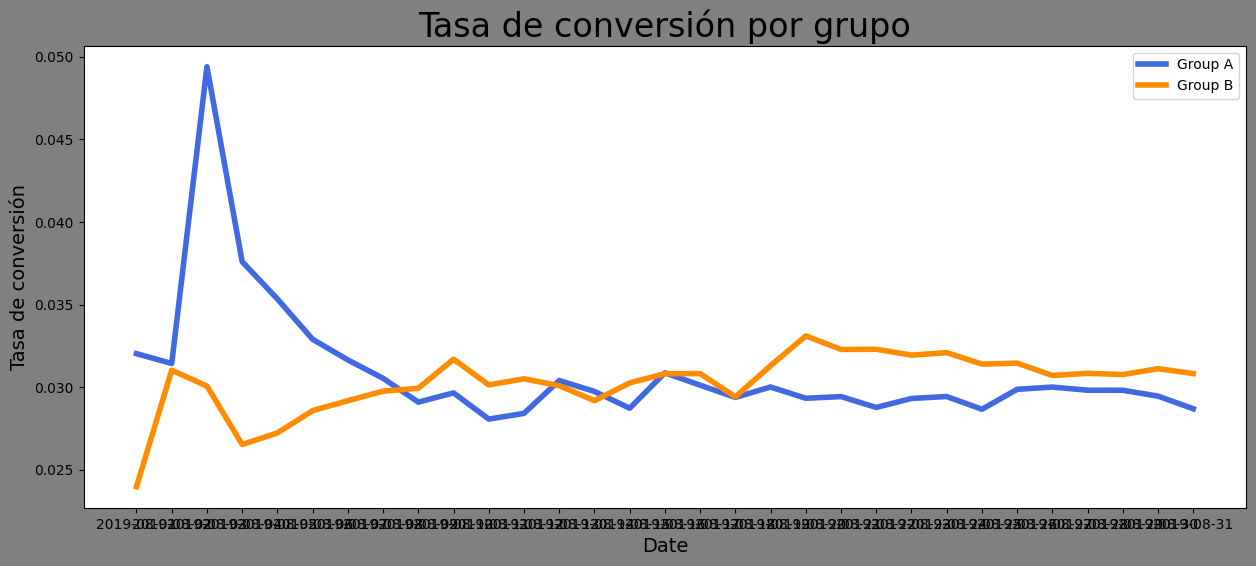

In [37]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(conversion_rate_A['date'], conversion_rate_A['conversion_rate'], 
         label = 'Group A', color = 'royalblue', linewidth=4.0)
plt.plot(conversion_rate_B['date'], conversion_rate_B['conversion_rate'], 
         label = 'Group B', color = 'darkorange',linewidth=4.0)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Tasa de conversión', fontsize=14)
ax.set_title("Tasa de conversión por grupo", fontsize=24)
fig.patch.set_facecolor('grey')
plt.legend()

plt.show()

##### Conclusión: <br />
Como podemos ver, la conversión en el grupo B es más alta. Al final del período, los gráficos de conversión se han estabilizado.

#### 3.5 Trazar un gráfico de dispersión del número de pedidos por usuario.

In [38]:
number_orders_per_buyer = orders_filtred.groupby('visitorId').agg({'transactionId':'nunique'})
number_orders_per_buyer = ( 
    number_orders_per_buyer.rename(columns = {'transactionId':'count_orders'})
)
# calcular el número de clientes con un pedido
share_one_order = (
    len(number_orders_per_buyer[number_orders_per_buyer['count_orders'] == 1])
    /
    len(number_orders_per_buyer)
)
print('{:.2%} de usuarios realizaron solo una orden'.format(share_one_order))

96.30% de usuarios realizaron solo una orden


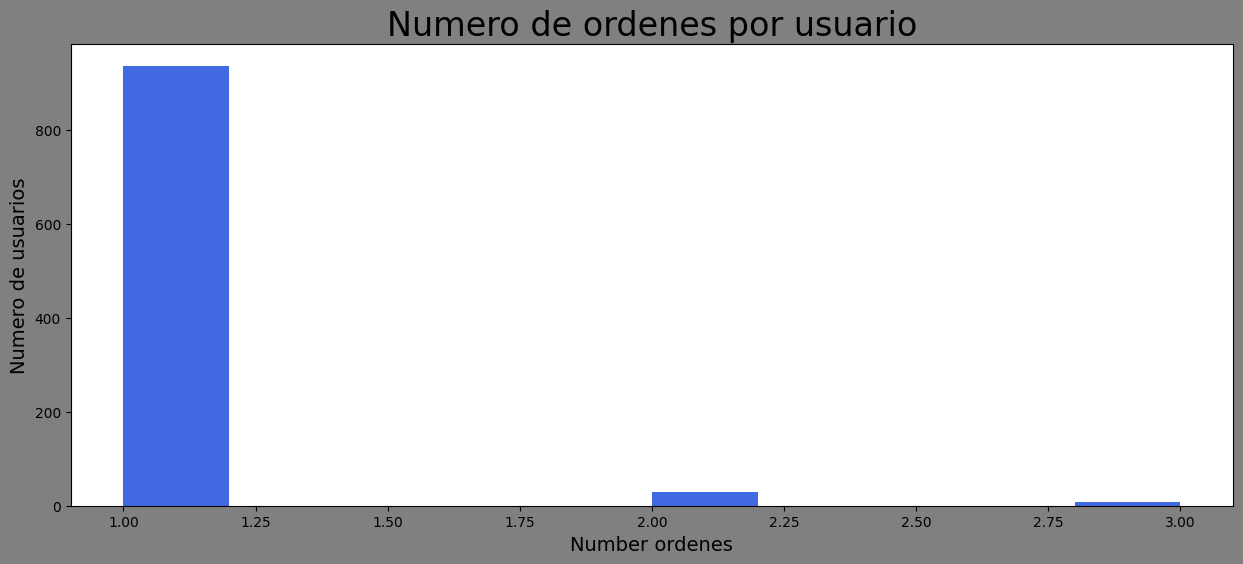

In [39]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.hist(number_orders_per_buyer['count_orders'], color = 'royalblue') 
ax.set_xlabel('Number ordenes', fontsize=14)
ax.set_ylabel('Numero de usuarios', fontsize=14)
ax.set_title('Numero de ordenes por usuario', fontsize=24)
fig.patch.set_facecolor('grey')

plt.show()

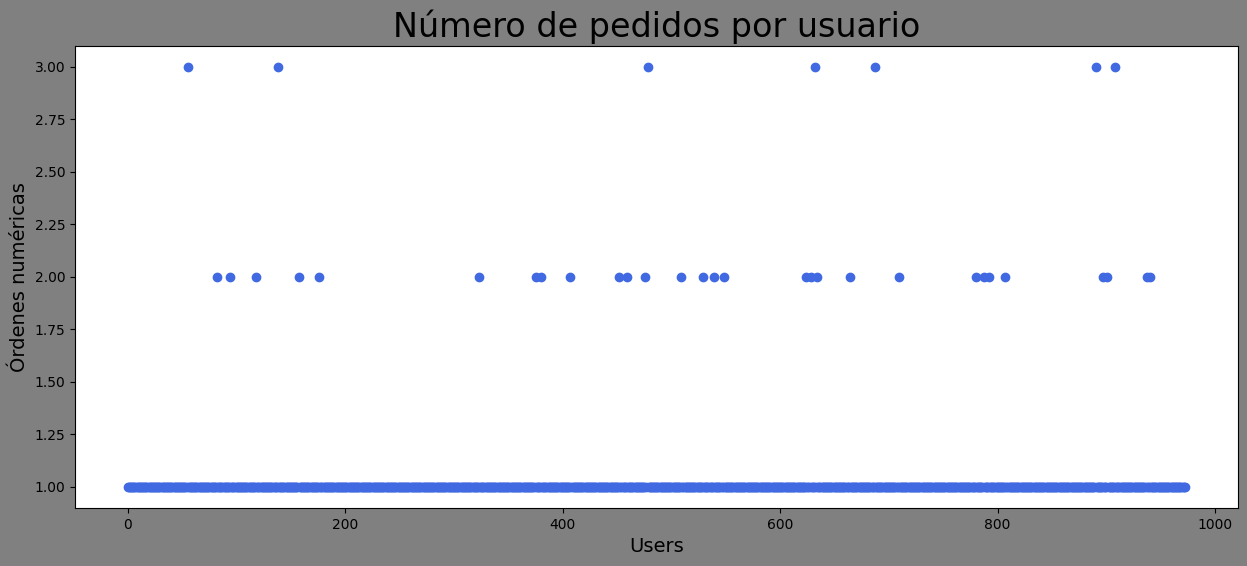

In [40]:
x_values = pd.Series(range(0,len(number_orders_per_buyer)))

fig, ax = plt.subplots(figsize=(15, 6))
plt.scatter(x_values, number_orders_per_buyer['count_orders'], color = 'royalblue') 
ax.set_xlabel('Users', fontsize=14)
ax.set_ylabel("Órdenes numéricas", fontsize=14)
ax.set_title("Número de pedidos por usuario", fontsize=24)
fig.patch.set_facecolor('grey')

plt.show()

##### Conclusión: <br />
Como puedes ver en ambos gráficos, la mayoría de los clientes, **96.3%**, realizan solo un pedido. Es imposible decir inequívocamente si es mucho o poco. Si nuestra tienda vende alimentos, entonces esta es una tasa muy baja, ya que las personas compran alimentos con mucha más frecuencia que una vez al mes. Si nuestra tienda vende muebles, entonces no debes esperar que los clientes estén interesados en nuestros productos muy a menudo. Para cada industria, el número de pedidos por cliente por mes será diferente.

#### 3.6 Calcule los percentiles 95 y 99 del número de pedidos por usuario.

In [41]:
percentile_dict = [95, 99]
percentile = np.percentile(number_orders_per_buyer['count_orders'], percentile_dict)

print('no más del {:}% de usuarios realizaron más de {:.1f} pedidos'.
      format(100 - percentile_dict[0],percentile[0]))
print(
    "no más del {:}% de usuarios realizaron más de {:.1f} pedidos".format(
        100 - percentile_dict[1], percentile[1]
    )
)

no más del 5% de usuarios realizaron más de 1.0 pedidos
no más del 1% de usuarios realizaron más de 2.0 pedidos


Por lo general, se filtran los valores más extremos del 1 al 5% de los valores observados.<br />
Por lo tanto, sería correcto establecer **un** pedido por usuario como el límite inferior para el número de pedidos y filtrar anomalías en función de eso.

#### 3.7 Trazar un gráfico de dispersión de los precios de los pedidos.

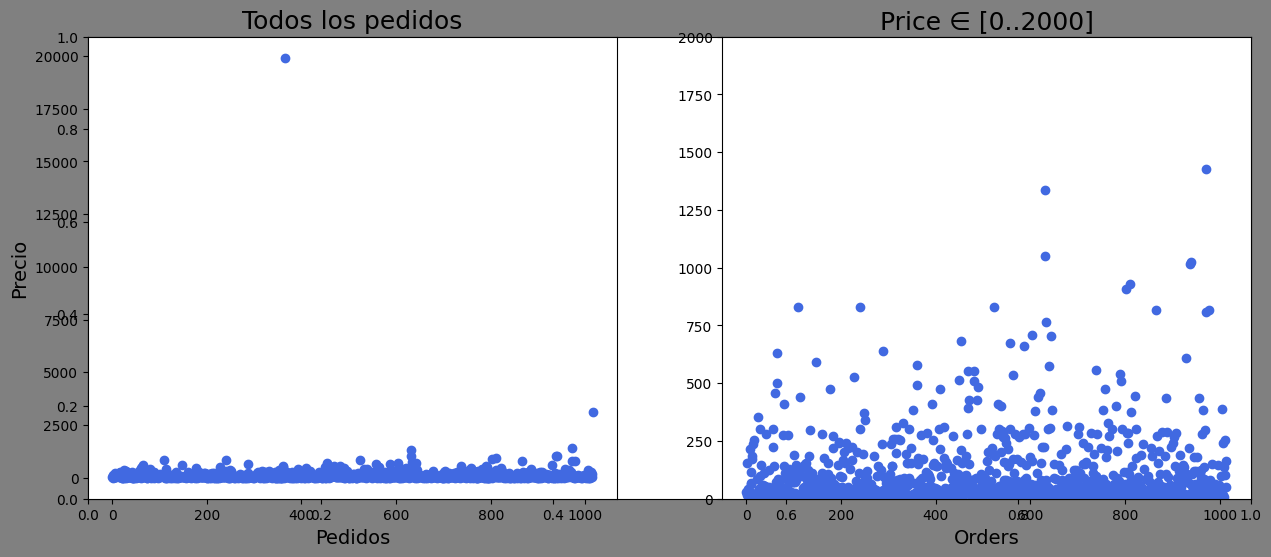

In [42]:
x_values = pd.Series(range(0,len(orders_filtred)))

fig, ax = plt.subplots(figsize=(15, 6))
fig.patch.set_facecolor('grey')
ax1 = plt.subplot(121)
res = plt.scatter(x_values, orders_filtred['revenue'], color = 'royalblue') 
ax1.set_ylabel('Precio', fontsize=14)       
ax1.set_xlabel('Pedidos', fontsize=14)
ax1.set_title('Todos los pedidos', fontsize=18)
    
ax2 = plt.subplot(122)
res = plt.scatter(x_values, orders_filtred['revenue'], color = 'royalblue') 

ax2.set_ylabel('')  
ax2.set_xlabel('Orders', fontsize=14)
ax2.set_title('Price ∈ [0..2000]', fontsize=18)
ax2.set_ylim([0, 2000])
plt.show()

##### Conclusión: <br />
Tal como esperábamos, hay varios pedidos grandes.<br />
La mayoría de los clientes realizan pedidos de hasta $ 500. En la próxima parte, aprenderemos el umbral de corte.

#### 3.8 Calcule los percentiles 95 y 99 de los precios de los pedidos.

In [43]:
percentile = np.percentile(orders_filtred['revenue'], percentile_dict)
print(
    "No más del {:}% de los usuarios realizaron pedidos superiores a {:.1f} dolares".format(
        100 - percentile_dict[0], percentile[0]
    )
)
print(
    "No más del {:}% de los usuarios realizaron pedidos superiores a {:.1f} dolares".format(
        100 - percentile_dict[1], percentile[1]
    )
)

No más del 5% de los usuarios realizaron pedidos superiores a 414.3 dolares
No más del 1% de los usuarios realizaron pedidos superiores a 830.3 dolares


##### Conclusión: <br />
Por lo general, se filtran los valores más extremos del 1 al 5% de los valores observados.<br />
Por lo tanto, sería correcto establecer $500 por pedido como el límite superior y filtrar anomalías en función de eso.

#### 3.9 Encuentre la significación estadística de la diferencia en la conversión entre los grupos utilizando los datos sin procesar.

Hipótesis Nula: No hay diferencia en la conversión entre los grupos.

Hipótesis Alternativa: Hay una diferencia en la conversión entre los grupos.

En este caso: Hipótesis sobre la Igualdad de Dos Medias Poblacionales.

Cada muestra tiene más de 50 registros, lo que significa que las muestras son lo suficientemente grandes para probar hipótesis.

Establecemos alfa = 0.05, ya que estamos evaluando una hipótesis para un problema empresarial.

Para probar las hipótesis, utilizamos el método de Mann-Whitney.


In [44]:
# orders_filtred - tabla de la que se eliminaron duplicados en la primera parte del proyecto
# contando el número de compradores y el número de pedidos
ordersByUsers_A = ( 
    orders_filtred[orders_filtred['group'] == 'A'].
    groupby('visitorId').
    agg({'transactionId':'nunique'})
)

ordersByUsers_B = ( 
    orders_filtred[orders_filtred['group'] == 'B'].
    groupby('visitorId').
    agg({'transactionId':'nunique'})
)

ordersByUsers_A = ordersByUsers_A.rename(columns = {'transactionId':'orders'})
ordersByUsers_B = ordersByUsers_B.rename(columns = {'transactionId':'orders'})

In [45]:
# Crear una tabla para el análisis de conversión
sampleA = (
    pd.concat([ordersByUsers_A['orders'],
               pd.Series(0, 
                         index = np.arange(visits_filtred[visits_filtred['group'] == 'A']
                                           ['visits']
                                           .sum() 
                                           -
                                           len(ordersByUsers_A['orders'])),
                         name = 'orders')],
              axis=0)
)
sampleB = (
    pd.concat([ordersByUsers_B['orders'],
               pd.Series(0, 
                         index = np.arange(visits_filtred[visits_filtred['group'] == 'B']
                                           ['visits']
                                           .sum() 
                                           -
                                           len(ordersByUsers_B['orders'])),
                         name = 'orders')],
              axis=0)
)

In [46]:
# Averigüemos si podemos rechazar la hipótesis nula de que no existe
# una diferencia estadísticamente significativa en la conversión entre los grupos.

print("P-value : {0:.4f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print("Conversion en el grupo B es mejor por {0:.0f}%".

      format((sampleB.mean()/sampleA.mean()-1)*100))

P-value : 0.1819
Conversion en el grupo B es mejor por 7%


##### Conclusión:<br />
Basándonos en los datos sin procesar, hay una diferencia entre los grupos A y B.<br />
El valor p es 0.006, que es menor que 0.05. Por lo tanto, podemos rechazar la hipótesis nula de que no hay una diferencia estadísticamente significativa en la conversión entre los grupos. La victoria relativa del grupo B es del 16%.

#### 3.10 Encuentre la significancia estadística de la diferencia en el tamaño promedio de los pedidos entre los grupos utilizando los datos sin procesar.

Hipótesis Nula: El tamaño promedio del pedido es el mismo en ambos grupos.<br />
Hipótesis Alternativa: El tamaño promedio del pedido es diferente en ambos grupos.

En este caso: Hipótesis sobre la Igualdad de Dos Medias Poblacionales.
Cada muestra tiene más de 50 registros, lo que significa que las muestras son lo suficientemente grandes para probar hipótesis.

Establecemos alfa = 0.05, ya que estamos evaluando una hipótesis para un problema empresarial.

Para probar las hipótesis, utilizamos el método de Mann-Whitney.


In [47]:
revenue_A = orders_filtred[orders_filtred['group'] == 'A']['revenue']
revenue_B = orders_filtred[orders_filtred['group'] == 'B']['revenue']
print("P-value : {0:.3f}".format(st.mannwhitneyu(revenue_A, revenue_B)[1]))
print(
    "El tamaño medio de los pedidos en el grupo B es mejor por {0:.3f}%".format(
        (revenue_B.mean() / revenue_A.mean() - 1) * 100
    )
)

P-value : 0.862
El tamaño medio de los pedidos en el grupo B es mejor por 27.834%


##### Conclusión:<br />
El valor p (**0.43**) es considerablemente más alto que 0.05, por lo que no hay razón para rechazar la hipótesis nula y concluir que el tamaño promedio del pedido difiere entre los grupos. El tamaño promedio del pedido para el grupo B es mucho más grande que para el grupo A (**28%**).

#### 3.11 Encuentre la significación estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados.

Como determinamos anteriormente, los pedidos superiores a $500 o más de un pedido por cliente se considerarían anormales.

In [48]:
ordersByUsers_A = ordersByUsers_A.reset_index()
ordersByUsers_B = ordersByUsers_B.reset_index()

In [49]:
# generemos una tabla adicional con anomalías de uid
usersWithManyOrders = pd.concat(
    [ordersByUsers_A[ordersByUsers_A['orders'] > 1]['visitorId'],
     ordersByUsers_B[ordersByUsers_B['orders'] > 1]['visitorId']],
     axis = 0)

usersWithExpensiveOrders = orders_filtred[orders_filtred['revenue'] > 500]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders,usersWithExpensiveOrders],axis = 0)
abnormalUsers = abnormalUsers.drop_duplicates().sort_values()
print('Tenemos {:} usuarios anomalos en total.'.format(len(abnormalUsers)))

Tenemos 72 usuarios anomalos en total.


Intentemos averiguar cómo las acciones anómalas de los usuarios afectaron los resultados de la prueba. Calcularemos la significancia estadística de las diferencias en la conversión entre los grupos, utilizando datos filtrados. Primero prepararemos muestras del número de pedidos por usuario para cada grupo de prueba.

In [50]:
sampleA_filtered = ( 
    pd.concat(
        [ordersByUsers_A[np.logical_not(ordersByUsers_A['visitorId'].
                                        isin(abnormalUsers))]['orders'],
         pd.Series(0, 
                   index = np.arange(visits_filtred[visits_filtred['group']=='A']
                                     ['visits'].sum() 
                                     - 
                                     len(ordersByUsers_A['orders'])),
                   name='orders')],
        axis=0)
)
sampleB_filtered = ( 
    pd.concat(
        [ordersByUsers_B[np.logical_not(ordersByUsers_B['visitorId'].
                                        isin(abnormalUsers))]['orders'],
         pd.Series(0, 
                   index = np.arange(visits_filtred[visits_filtred['group']=='B']
                                     ['visits'].sum() 
                                     - 
                                     len(ordersByUsers_B['orders'])),
                   name='orders')],
        axis=0)
)

Hipótesis Nula: No hay diferencia en la conversión entre los grupos de los cuales se han eliminado las anomalías.<br />
Hipótesis Alternativa: Hay una diferencia en la conversión entre los grupos de los cuales se han eliminado las anomalías.
<br /><br />
En este caso: Hipótesis sobre la Igualdad de Dos Medias Poblacionales.

Cada muestra tiene más de 50 registros, lo que significa que las muestras son lo suficientemente grandes para probar hipótesis.

Establecemos alfa = 0.05, ya que estamos evaluando una hipótesis para un problema empresarial.
<br /><br />
Para probar las hipótesis, utilizamos el método de Mann-Whitney.

In [51]:
print("P-value : {0:.4f}".format(st.mannwhitneyu(sampleA_filtered, sampleB_filtered)[1]))
print("Conversion en el grupo B es mejor por {0:.0f}%".
      format((sampleB_filtered.mean()/sampleA_filtered.mean()-1)*100))

P-value : 0.1541
Conversion en el grupo B es mejor por 10%


##### Conclusión:<br />
El valor p es 0.005, que es menor que 0.05. Por lo tanto, podemos rechazar la hipótesis nula.
Encontramos que, según los datos "purificados", la conversión por grupos también difirió de manera estadísticamente significativa. La proporción de los valores medios prácticamente no cambió.
Resulta que los usuarios "anómalos" tuvieron prácticamente ningún efecto en el valor de esta métrica.

#### 3.12 Encuentre la significación estadística de la diferencia en el tamaño promedio de los pedidos entre los grupos utilizando los datos filtrados.


Hipótesis Nula: Después de eliminar las anomalías, el tamaño promedio del pedido en ambos grupos es el mismo.<br />
Hipótesis Alternativa: Después de eliminar las anomalías, el tamaño promedio del pedido en ambos grupos es diferente.
   
En este caso: Hipótesis sobre la Igualdad de Dos Medias Poblacionales.
Cada muestra tiene más de 50 registros, lo que significa que las muestras son lo suficientemente grandes para probar hipótesis.

Establecemos alfa = 0.05, ya que estamos evaluando una hipótesis para un problema empresarial.
<br /><br />
Para probar las hipótesis, utilizamos el método de Mann-Whitney.


In [52]:
revenue_A_filtered = (
    orders_filtred[(np.logical_not(orders_filtred['visitorId'].
                                   isin(abnormalUsers)))                
                   & (orders_filtred['group'] == 'A')])['revenue']
revenue_B_filtered = (
    orders_filtred[(np.logical_not(orders_filtred['visitorId'].
                                   isin(abnormalUsers)))                
                   & (orders_filtred['group'] == 'B')])['revenue']

In [53]:
print("P-value : {0:.3f}"
      .format(st.mannwhitneyu(revenue_A_filtered, revenue_B_filtered)[1]))
print(
    "El tamaño promedio de los pedidos en el grupo B es mejor en {0:.1f}%".format(
        (revenue_B_filtered.mean() / revenue_A_filtered.mean() - 1) * 100
    )
)

P-value : 0.992
El tamaño promedio de los pedidos en el grupo B es mejor en 1.6%


##### Conclusión:<br />
El valor p (**0.49**) es considerablemente más alto que 0.05, por lo que no hay razón para rechazar la hipótesis nula y concluir que el tamaño promedio del pedido difiere entre los grupos. <br />
En los datos filtrados, el tamaño promedio del pedido para el grupo B es el mismo que para el grupo A. Podemos concluir que los valores anómalos influyeron enormemente en el resultado obtenido anteriormente. Sin valores anómalos, el valor promedio del pedido no cambia.

##### Conclusiones sobre las pruebas A / B:<br />

- existen diferencias estadísticamente significativas en la conversión entre los grupos A y B (tanto en los datos sin procesar como en los datos purificados)<br />
- no existen diferencias estadísticamente significativas en el ticket promedio entre los grupos A y B (tanto para los datos sin procesar como para los datos purificados).

#### 3.13 Tomar una decisión basada en los resultados de la prueba.

Como resultado de los datos obtenidos, puedo aconsejarte que detengas las pruebas. El resultado de la prueba puede considerarse positivo. Determinamos que los datos en los grupos son estadísticamente diferentes, y el resultado en el grupo B es un 19% mejor. En cuanto al ticket promedio, no ha cambiado entre los grupos A y B. Esto nos indica que nuestro cambio mejorará las conversiones y mantendrá el valor promedio del pedido en el mismo nivel.

### 4. Conclusiones Generales

1. Durante la ejecución de este proyecto, se descubrió que algunos usuarios participaron en dos grupos al mismo tiempo, lo cual viola uno de los principios básicos de la prueba A / B: un usuario ve solo una versión del sitio durante toda la prueba.<br />Por lo tanto, necesitamos verificar la corrección del procesamiento del método de mostrar una u otra versión del sitio a los usuarios.<br /><br />

2. Se calculó la prioridad de las pruebas de hipótesis utilizando el método RICE. Las siguientes hipótesis recibieron la mayor prioridad:<br />
   - "Agregar un formulario de suscripción a todas las páginas principales".<br />
   - "Agregar bloques de recomendación de productos al sitio web de la tienda".<br /><br />

3. Obtuvimos los resultados de las pruebas A / B. El resultado de la prueba puede considerarse positivo. Basándonos en los resultados de la prueba, se encontró que la tasa de conversión aumentará cuando se realicen cambios, y el precio promedio se mantendrá igual.<br />
Al analizar los datos, se encontró que más del 96% de los clientes realizan solo un pedido de hasta $413. Sin embargo, hay clientes que realizan 3 o más pedidos.